# Useful geospatial libraries for Data Analysis in Python

In this short tutorial we will be looking at some of the common geospatial Python libraries that can be useful for researchers dealing with spatial data.

As an example, we will try to extract basic statistics on precipitation in the period 2016&ndash;2020 for the Emajõgi catchment in Tartu County, Estonia.

Our workflow will be as follows
* Read and preprocess vector data with GeoPandas
* Rasterize vector points into a grid with Geocube
* Read and reproject raster data with Rasterio
* Extract zonal statistics with Rasterstats

## Vector data preprocessing with GeoPandas

We will start by reading the catchments from the corresponding shapefile. As mentioned above, the GeoPandas library can be used for vector data processing.

In [11]:
import geopandas as gpd

In [58]:
catchments = gpd.read_file('data/catchments.shp')

The data is now in a GeoDataFrame, which allows for tabular processing of geospatial data. It is similar to how an attribute table can be viewed in GIS software like QGIS or ArcGIS.

In [48]:
catchments.head()

,kood,nimi,Pindala,geometry
0,1022700_1,Tamme,10.0312,"POLYGON ((626095.000 6458390.000, 626110.000 6..."
1,1022800_1,Ubesoo,98.1972,"POLYGON ((631770.000 6453815.000, 631770.000 6..."
2,1022300_1,Nigula,35.8977,"POLYGON ((629375.000 6451310.000, 629375.000 6..."
3,1022200_1,Ahtmiku,16.5277,"POLYGON ((623265.000 6445715.000, 623265.000 6..."
4,1021500_1,Rõngu,111.2170,"POLYGON ((629255.000 6443980.000, 629215.000 6..."


We will check to see the CRS of the data and see that it is in the official Estonian CRS indicated by the code EPSG:3301.

In [59]:
catchments.crs

<Projected CRS: EPSG:3301>
Name: Estonian Coordinate System of 1997
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Estonia - onshore and offshore.
- bounds: (20.37, 57.52, 28.2, 60.0)
Coordinate Operation:
- name: Estonian National Grid
- method: Lambert Conic Conformal (2SP)
Datum: Estonia 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

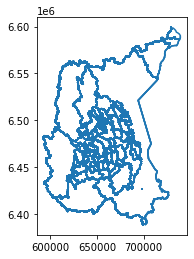

In [50]:
catchments.boundary.plot()

We are interested in the Emajõgi catchment, so we will extract it from the rest.

In [60]:
ema_catchment = catchments[catchments['nimi'] == 'Emajõgi'].reset_index(drop=True)

In [61]:
ema_catchment

,kood,nimi,Pindala,geometry
0,1023600_1,Emajõgi,9770.24,"POLYGON ((632155.000 6564105.000, 632155.000 6..."


As we have chosen our study area to be only within the borders of Tartu County, we will need to clip the catchment with the county borders. We will read in the Estonian counties and check out the CRS.

In [53]:
counties = gpd.read_file('data/maakond_20211001.shp')
counties.head()

,MNIMI,MKOOD,geometry
0,Saare maakond,0074,"MULTIPOLYGON (((455191.283 6404986.597, 455187..."
1,Viljandi maakond,0084,"MULTIPOLYGON (((621049.180 6453125.120, 621052..."
2,Hiiu maakond,0039,"MULTIPOLYGON (((418045.779 6506293.321, 418044..."
3,Harju maakond,0037,"MULTIPOLYGON (((505059.934 6570389.813, 505061..."
4,Lääne maakond,0056,"MULTIPOLYGON (((460628.287 6512871.566, 460630..."


In [54]:
counties.crs

<Projected CRS: EPSG:3301>
Name: Estonian Coordinate System of 1997
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Estonia - onshore and offshore.
- bounds: (20.37, 57.52, 28.2, 60.0)
Coordinate Operation:
- name: Estonian National Grid
- method: Lambert Conic Conformal (2SP)
Datum: Estonia 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

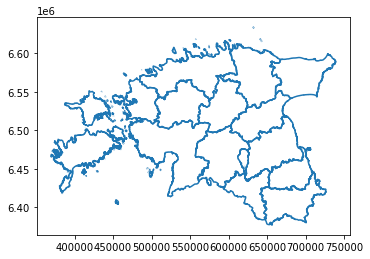

In [55]:
counties.boundary.plot()

We can extract Tartu County like we did before with Emajõgi.

In [43]:
tartu = counties[counties['MNIMI'] == 'Tartu maakond'].reset_index(drop=True)

<AxesSubplot:>

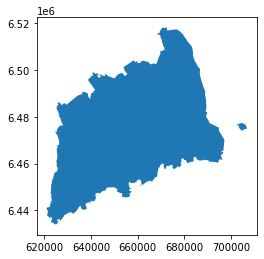

In [44]:
tartu.plot()

Now we can clip out the Tartu County section of the Emajõgi catchment and write it into a new shapefile.

In [64]:
ema_catchment_tartu = gpd.clip(ema_catchment, mask=tartu)

<AxesSubplot:>

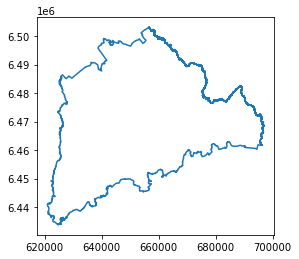

In [65]:
ema_catchment_tartu.boundary.plot()

In [66]:
ema_catchment_tartu.to_file('data/ema_catchment_tartu.shp')

## Rasterization with geocube

We are going to use a CSV file of mean annual total precipitation from the period 2016 to 2020 in Estonia. It contains measurements originally provided by the Copernicus ERA5-Land reanalysis product. The data is in WGS84 coordinates.

For reading the data we use the Pandas library, which is a very useful library for tabular data processing. In fact, GeoPandas is the geospatial extension of Pandas.

In [3]:
import pandas as pd

In [9]:
df = pd.read_csv('data/precip_mean.csv', sep=',')

In [10]:
df.head()

,longitude,latitude,year,tp
0,21.0,60.0,2016,NaN
1,21.0,60.0,2017,NaN
2,21.0,60.0,2018,NaN
3,21.0,60.0,2019,NaN
4,21.0,60.0,2020,NaN


Currently the data is in a regular DataFrame without spatial information. For rasterization we first need to convert it into a GeoDataFrame and create points from longitude and latitude coordinates.

In [12]:
gdf = gpd.GeoDataFrame(df, crs=4326, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

In [13]:
gdf.head()

,longitude,latitude,year,tp,geometry
0,21.0,60.0,2016,NaN,POINT (21.00000 60.00000)
1,21.0,60.0,2017,NaN,POINT (21.00000 60.00000)
2,21.0,60.0,2018,NaN,POINT (21.00000 60.00000)
3,21.0,60.0,2019,NaN,POINT (21.00000 60.00000)
4,21.0,60.0,2020,NaN,POINT (21.00000 60.00000)


## Rasterization with Geocube

We can now rasterize the measurements. We will use the Geocube library for this purpose. The function make_geocube allows us to convert a GeoDataFrame into a raster grid.

We need to tell the function, which column of the GeoDataFrame will be used as measurements and assign a suitable output resolution. In our case, we know that the ERA5-Land product originally had a coarse resolution of 0.1 degrees in WGS84, so that is what we will use.

In [15]:
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata

In [16]:
grid = make_geocube(gdf, measurements=['tp'], resolution=(-0.1, 0.1), rasterize_function=rasterize_points_griddata)

The output is an Xarray dataset. Xarray is a Python library useful for dealing with some specific types of gridded data, e.g. NetCDF or GRIB files.

In [17]:
grid

<xarray.Dataset>
Dimensions:      (y: 30, x: 80)
Coordinates:
  * y            (y) float64 59.95 59.85 59.75 59.65 ... 57.35 57.25 57.15 57.05
  * x            (x) float64 21.05 21.15 21.25 21.35 ... 28.65 28.75 28.85 28.95
    spatial_ref  int32 0
Data variables:
    tp           (y, x) float64 nan nan nan nan nan ... 559.9 693.0 567.0 695.0

Now we can export the grid into a GeoTIFF file.

In [27]:
grid['tp'].rio.to_raster('data/precip_mean_4326.tif')

## Reproject raster with Rasterio

Rasterio is a library used for processing raster data. It is often useful when you need to reproject or modify a raster file in any other way. It can also be used to visualize raster data in Python.

In [19]:
import rasterio

In [28]:
dataset = rasterio.open('data/precip_mean_4326.tif')

In [29]:
dataset.crs

CRS.from_epsg(4326)

For a basic plot of the data we can use the show function from Rasterio.

In [30]:
from rasterio.plot import show

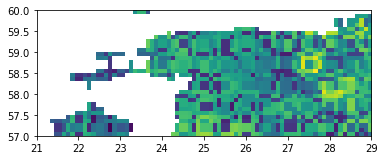

<AxesSubplot:>

In [31]:
show(dataset)

The show_hist command allows us to quickly check out the distribution of annual mean precipitation values in the Estonian region.

In [32]:
from rasterio.plot import show_hist

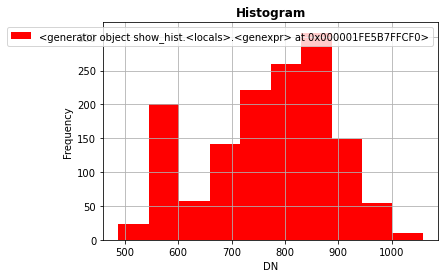

In [33]:
show_hist(dataset)

Next we will reproject the raster into the Estonian CRS and export it as a new GeoTIFF. We will use a few helper function from Rasterio for this part.

The function calculate_default_transform will help us get the transformation algorithm needed for converting the data from EPSG:4326 to EPSG:3301. Function reproject will take the source data in its original CRS and project it into the requested output CRS. We overwrite the keyword arguments from source metadata based on the transformation algorithm as well.

In [34]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [35]:
dst_crs = 'epsg:3301'

In [37]:
with rasterio.open('data/precip_mean_4326.tif') as src:
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})
    with rasterio.open('data/precip_mean_3301.tif', 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1), 
            destination=rasterio.band(dst, 1), 
            src_transform=src.transform, 
            src_crs=src.crs, 
            dst_transform=transform, 
            dst_crs=dst_crs, 
            resampling=Resampling.nearest
        )

If we now look at the new file then we can see that we have the requested CRS assigned to it.

In [38]:
rasterio.open('data/precip_mean_3301.tif').crs

CRS.from_epsg(3301)

## Calculate zonal statistics with Rasterstats

We have now reached the final part of this basic tutorial, where we take the previously created raster dataset and extract some basic statistics about annual mean precipitation within the Emajõgi catchment.

We will read in the shapefile of the Emajõgi catchment as a GeoDataFrame.

In [40]:
ema_catchment_tartu = gpd.read_file('data/ema_catchment_tartu.shp')

<AxesSubplot:>

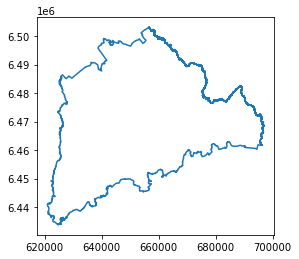

In [42]:
ema_catchment_tartu.boundary.plot()

Function zonal_stats from the Rasterstats library can take vector mask of polygons either in the form of a GeoDataFrame object or a shapefile and calculate raster statistics based on the extent of input polygons.

In [47]:
from rasterstats import zonal_stats

In [49]:
stats = zonal_stats(ema_catchment_tartu, 'data/precip_mean_3301.tif', stats=['min', 'max', 'mean', 'std', 'range'], prefix='precip_')

The output is a Python list of dictionaries. In our case, we only had a single polygon, but the process can be used to extract statistics from many polygons as well.

In [50]:
stats

[{'precip_min': 538.6592,
  'precip_max': 856.6505,
  'precip_mean': 700.8437436363636,
  'precip_std': 89.78773538804293,
  'precip_range': 317.9912999999999}]

In [52]:
stats_df = pd.DataFrame(stats)

In [53]:
stats_df

,precip_min,precip_max,precip_mean,precip_std,precip_range
0,538.6592,856.6505,700.843744,89.787735,317.9913


This concludes our basic tutorial. The libraries used here are documented well in the corresponding online resource pages, so you can always find examples of how to carry out certain processing steps.